# Part 3 - Advanced Machine Learning
In part one we achieved around 67% accuracy on GalaxyMNIST using a kNN-classifier. Ultimately our goal is to get the highest possible score on GalaxyMNIST which can most likely be achieved using Convolutional Neural Networks. It is good practice to compare against simple baselines when developing more complex models. In this notebook, we will start with simple non-neural network classifiers and then move on to fully connected and convolutional neural networks.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import urllib
import shutil
import torch
import gzip
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

try:
    from galaxy_mnist import GalaxyMNIST
except ImportError:
    !pip install git+https://github.com/mwalmsley/galaxy_mnist.git
    from galaxy_mnist import GalaxyMNIST

download_data = [{"url":"https://www.dropbox.com/scl/fi/l4ap5eq7z49l27dnfw076/train_dataset.hdf5.gz?rlkey=gjfrrrouoah0hbydbkpfx66as&st=tw6znd55&dl=1", "zipfile": "train_dataset.hdf5.gz", "file": "train_dataset.hdf5"},
{"url": "https://www.dropbox.com/scl/fi/ty43vhrrpa8cf8azn3awn/test_dataset.hdf5.gz?rlkey=jmlkzjiguhe271nbuzpa0njna&st=5oco8ika&dl=1", "zipfile": "test_dataset.hdf5.gz","file": "test_dataset.hdf5"}]

root_folder = Path("raw_galaxy_mnist")
download_folder = root_folder / "GalaxyMNIST" / "raw"
download_folder.mkdir(parents=True, exist_ok=True)
for info in download_data:
    if not (download_folder / info["file"]).exists(): # Check if data exists, if not download and unpack
        urllib.request.urlretrieve(info["url"], download_folder / info["zipfile"])
        with gzip.open(download_folder / info["zipfile"], 'rb') as f_in:
            with open(download_folder / info["file"], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

dataset = GalaxyMNIST(root=root_folder, train=True)
val_dataset = GalaxyMNIST(root=root_folder, train=False)

In [2]:
# Extract data and targets
raw_images, labels = dataset.data, dataset.targets
raw_test_images, test_labels = val_dataset.data, val_dataset.targets
num_classes = len(dataset.classes)

# Standardize training data
raw_images_float = raw_images.float() / 255.0
train_mean = raw_images_float.mean(dim=(0, 2, 3)).view(1, -1, 1, 1)
train_std = raw_images_float.std(dim=(0, 2, 3)).view(1, -1, 1, 1)
images = (raw_images_float - train_mean) / train_std

raw_test_images_float = raw_test_images.float() / 255.0
test_images = (raw_test_images_float - train_mean) / train_std

flattened_images = images.flatten(1)
flattened_test_images = test_images.flatten(1)

## 3.1 Classical Algorithms
- Identify at least three classification algorithms that can be used for image classification.
- Explain briefly how they work and use them to classify the dataset.
- Compare their metrics and runtime, which is best?

For possible algorithm options you can get inspired [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

Tree-based models like Decision Trees, Random Forests, and Gradient Boosting work well for galaxy classification. They can handle nonlinear patterns in high denmentional space. Random Forests and Boosting are accurate and robust. Trees also give feature importance and are easy to interpret. Other models like SVM or k-NN often require more tuning. And Random Forest and Gradient Boosting reduce overfitting. 

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
import time

In [9]:
# decision tree
start_time = time.time()

# Train the Decision Tree
dt = DecisionTreeClassifier()      # Initialize the classifier (default)
dt.fit(flattened_images, labels)   # .fit() method trains the decision tree on training data

# Predict on test data
predicted_dt = dt.predict(flattened_test_images)

end_time = time.time()

# runtime
runtime = end_time - start_time
print(f"Decision Tree runtime (training + prediction): {runtime:.4f} seconds")

Decision Tree runtime (training + prediction): 91.9537 seconds


In [ ]:
# random forest
start_time = time.time()

# Train the random forest
rf = RandomForestClassifier(n_estimators=100)   # 100 trees for stronger learning
rf.fit(flattened_images, labels)

# Predict on test data
predicted_rf = rf.predict(flattened_test_images)

end_time = time.time()

# runtime
runtime = end_time - start_time
print(f"Random forest runtime (training + prediction): {runtime:.4f} seconds")

Random forest runtime (training + prediction): 58.6369 seconds


In [7]:
# Gradient Boosting Classifier
start_time = time.time()

# Train the gradient boosting
gb = GradientBoostingClassifier(n_estimators=20)   # 20 trees
gb.fit(flattened_images, labels)

# Predict on test data
predicted_gb = gb.predict(flattened_test_images)

end_time = time.time()

# runtime
runtime = end_time - start_time
print(f"Gradient boosting runtime (training + prediction): {runtime:.4f} seconds")

Gradient boosting runtime (training + prediction): 1188.8294 seconds


In [10]:
print("Decision Tree:")
print(classification_report(test_labels, predicted_dt))

print("Random Forest Classifier:")
print(classification_report(test_labels, predicted_rf))

Decision Tree:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       507
           1       0.51      0.49      0.50       506
           2       0.51      0.53      0.52       507
           3       0.63      0.64      0.63       480

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       507
           1       0.66      0.68      0.67       506
           2       0.66      0.66      0.66       507
           3       0.82      0.81      0.82       480

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



In [11]:
print("Gradient Boosting Classifier:")
print(classification_report(test_labels, predicted_gb))

Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       507
           1       0.59      0.64      0.61       506
           2       0.61      0.57      0.59       507
           3       0.75      0.75      0.75       480

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



Random Forest performed best overall. It had the fastest runtime and the highest precision and F1-score at the same tree depth. Decision Tree was second-fastest but had the lowest accuracy. Gradient Boosting was more accurate than the Decision Tree, but much slower than both. Therefore, Random Forest is the best choice in terms of both speed and accuracy. The reason why Gradient Boosting performs less than Random Forest is, that we did not tune the algorithm specifically for our data set which could lead to overfitting. 

## 3.2 Neural Networks
We will now start to use neural networks to classify the GalaxyMNIST dataset.
### 3.2.1 Multi-Layer Perceptron (MLP)
In this task you will write all the infrastructure to train and evaluate a neural network on a dataset. We recommend using PyTorch, but you can use any other framework as well. You can use [this](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) tutorial to get started and follow the steps below:
- Define a torch dataset (use a `TensorDataset`) and data loaders for the dataset.
- Design a simple fully connected network.
- Write a training loop which computes output, loss and does an optimization step.
- Write an evaluation function that computes the predictions of the trained model on the test set. 
- Plot the training/test loss and accuracy against the number of epochs.

In [4]:
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# Define datasets and loaders
batch_size = 64

train_dataset = TensorDataset(images, labels)                          # torch dataset
test_dataset = TensorDataset(test_images, test_labels)  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # torch data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(train_dataset)

shuffle set to True to have the data reshuffled at every epoch. An epoch is one full pass through the entire training dataset. When training a model, especially with stochastic gradient descent (SGD) or mini-batch optimizers like Adam, we want the model to see data in a different order every epoch. batch_size describes how many samples per batch to load. 

TensorDataset has the shape dataset[i] = (image[i],label[i]) image[i] has shape (C,H,W)

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()        # call the constructor method of parent class
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()                  # activition function f(x)=max{0,x}
        self.fc1 = nn.Linear(3*64*64, 128)     # define 3 layers
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

forward() function. This is where the actual computation happens: An input is passed through the network layers and various functions to generate an output.

In [ ]:
model = MLP()   # constructor
# Hyperparameters
learning_rate = 0.001
num_epochs = 30

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)       # stochastic Gradient descent SGD (Impuls) avoiding gradient oszillating

# training loop
model.train()                                                    # enables training-specific behaviour
loss_list=[]
for epoch in range(num_epochs):
    for batch_idx, (data, label) in enumerate(train_loader):     # batch_idx index of current batch
        # loss
        output = model(data)                                   # output after one loop
        loss = criterion(output, label)                        # compute loss function

        # backprop
        loss.backward()                                         # compute gradient using backpropagating (chain rule)
        optimizer.step()                                        # update model parameters
        optimizer.zero_grad()                                   # clear old gradients

        if (batch_idx+1) % 125 == 0:                            # print loss after every 125 = 8000 / 64 batches
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")
            loss_list.append(loss.item())

Epoch 1, Batch 125, Loss: 1.3162784576416016
Epoch 2, Batch 125, Loss: 1.2222880125045776
Epoch 3, Batch 125, Loss: 1.1482748985290527
Epoch 4, Batch 125, Loss: 1.2018166780471802
Epoch 5, Batch 125, Loss: 1.0719972848892212
Epoch 6, Batch 125, Loss: 1.046657919883728
Epoch 7, Batch 125, Loss: 0.9746587872505188
Epoch 8, Batch 125, Loss: 0.8884423971176147
Epoch 9, Batch 125, Loss: 0.9526719450950623
Epoch 10, Batch 125, Loss: 0.9197757840156555
Epoch 11, Batch 125, Loss: 0.8227033019065857
Epoch 12, Batch 125, Loss: 0.7856168150901794
Epoch 13, Batch 125, Loss: 0.759818971157074
Epoch 14, Batch 125, Loss: 0.7249516248703003
Epoch 15, Batch 125, Loss: 0.774087131023407
Epoch 16, Batch 125, Loss: 0.7040231227874756
Epoch 17, Batch 125, Loss: 0.6275352239608765
Epoch 18, Batch 125, Loss: 0.6907768845558167
Epoch 19, Batch 125, Loss: 0.5854261517524719
Epoch 20, Batch 125, Loss: 0.7195718288421631
Epoch 21, Batch 125, Loss: 0.5801592469215393
Epoch 22, Batch 125, Loss: 0.5412731170654297


So in summary, we have run 125 Batchs for each epoch, then in each Batch there is 64 data to be processed which means in each epoch we processed 125 x 64 = 8000 data. And in total we have run 30 epoch. (8000 data repeated 30 times)

In [ ]:
num_correct = 0
test_loss = 0
num_samples = len(test_dataset)
num_batches = len(test_loader)       # 2000 / 64 = 31.25

# evaluation
model.eval()                                        # switch to evaluation-mode
with torch.no_grad():
    for eval_data, eval_label in test_loader:
        prediction = model(eval_data)
        test_loss += criterion(prediction, eval_label)
        num_correct += (prediction.argmax(1) == eval_label).sum()
test_loss /= num_batches      # average loss
print(f"Test error: \nAccuracy: {num_correct/num_samples*100:.2f}%\nAverage loss: {test_loss}")
# print(len(test_loader))

Test error: 
Accuracy: 74.20%
Average loss: 0.6161243915557861
32


We chose two model, stochastic Gradient descent (Impuls) + self-adaptive (Adam 2014) and SGD and find out, even though Adam has a quicker convergence and much small loss, the accuracy on the test data is less than SGD. Which could be that Adam is quickly overfitted with large amount of data. And in contrast, SGD with a less convergence rate yields a better accuracy on the test dataset.

In [46]:
# training loop
loss_list=[]
loss_test_list = []
acc_test_list = []
for num_epochs in range(1,50):
    
    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  
    
    model.train()                                                    
    for epoch in range(num_epochs):
        for batch_idx, (data, label) in enumerate(train_loader):    
            # loss
            output = model(data)                                   
            loss = criterion(output, label)                        

            # backprop
            loss.backward()                                         
            optimizer.step()                                      
            optimizer.zero_grad()                                 

            #if (batch_idx+1) % 125 == 0:                            
                # print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")
    loss_list.append(loss.item())

    test_loss = 0
    num_correct = 0
    model.eval()                                       
    with torch.no_grad():
        for eval_data, eval_label in test_loader:
            prediction = model(eval_data)
            test_loss += criterion(prediction, eval_label)
            num_correct += (prediction.argmax(1) == eval_label).sum()
    test_loss /= num_batches
    print(f"Epoch {num_epochs}, {test_loss}")
    print(num_correct/num_samples*100, '%')

    loss_test_list.append(test_loss)
    acc_test_list.append(num_correct/num_samples*100)
    test_loss = 0
    num_correct = 0

Epoch 1, 1.337014079093933
tensor(36.4000) %
Epoch 2, 1.2244001626968384
tensor(48.2500) %
Epoch 3, 1.2968240976333618
tensor(46.1500) %
Epoch 4, 1.172249436378479
tensor(56.2500) %
Epoch 5, 1.1535234451293945
tensor(52.2500) %
Epoch 6, 1.0841320753097534
tensor(57.8500) %
Epoch 7, 1.064683437347412
tensor(61.2500) %
Epoch 8, 0.9673925042152405
tensor(59.9000) %
Epoch 9, 0.9564957618713379
tensor(62.9500) %
Epoch 10, 0.9308187961578369
tensor(63.) %
Epoch 11, 0.8640064001083374
tensor(67.5500) %
Epoch 12, 0.8162903785705566
tensor(70.1000) %
Epoch 13, 0.7761751413345337
tensor(69.5000) %
Epoch 14, 0.7324569225311279
tensor(69.1500) %
Epoch 15, 0.9366794228553772
tensor(63.4000) %
Epoch 16, 0.7135648131370544
tensor(70.2500) %
Epoch 17, 0.7509546875953674
tensor(69.6000) %
Epoch 18, 0.6983433961868286
tensor(70.8500) %
Epoch 19, 0.8160480260848999
tensor(67.0500) %
Epoch 20, 0.681789755821228
tensor(72.0500) %
Epoch 21, 0.6447797417640686
tensor(74.6500) %
Epoch 22, 0.6706358790397644
t

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


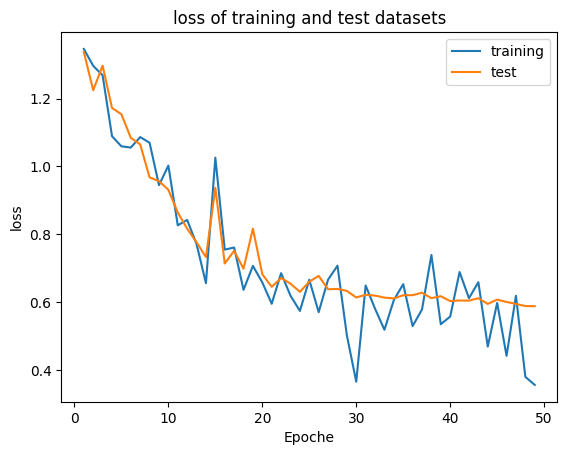

In [47]:
x_range = np.arange(49) +1
print(x_range)
plt.plot(x_range, loss_list, label='training')
plt.plot(x_range, loss_test_list, label='test')
plt.title('loss of training and test datasets')
plt.xlabel('Epoche')
plt.ylabel('loss')

plt.legend()
plt.show()

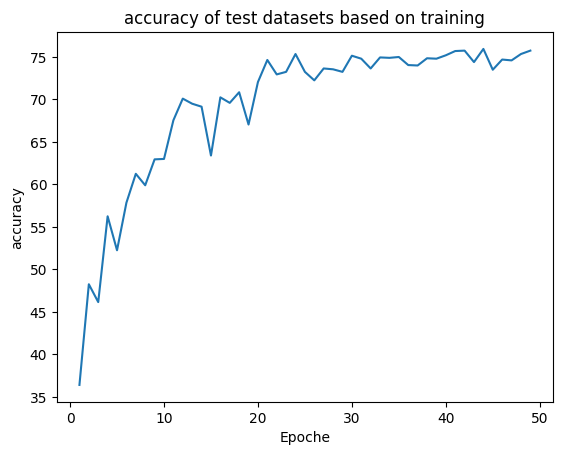

In [48]:
plt.plot(x_range, acc_test_list)
plt.title('accuracy of test datasets based on training')
plt.xlabel('Epoche')
plt.ylabel('accuracy')

plt.show()

### 3.2.2  CNN
MLPs are a simple form of neural networks. However, inserting prior knowledge about the structure of the data can help improve the performance. Convolutional Neural Networks (CNNs) are a type of neural network that is well-suited for image classification tasks.
- Design a CNN and train it on the dataset.
- Can an MLP learn to act like a CNN?

In [49]:
batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # torch data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(train_dataset)

In [51]:
class galaxy_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)   # 3 input image channel (RGB), 6 output channels, 5x5 square convolution kernel
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(8*8*10, 18)
        self.fc2 = nn.Linear(18, 10)
        self.fc3 = nn.Linear(10, 4)       # 4 output classes (galaxy types)

        # Activation and pooling
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)


    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.shape[0], -1)        # flatten for fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

The model architecture, defined in the GalaxyCNN class, consists of two convolutional layers followed by two max-pooling layers. The first convolutional layer maps the input from 3 channels to 6 feature maps using 5×5 filters, followed by ReLU activation and a 3×3 max-pooling operation (take the max element of 3 x 3 matrix). The second convolutional layer maps the output to 10 feature maps, again using 5×5 filters, followed by ReLU and 2×2 max-pooling. The resulting feature map of shape (10, 8, 8) is flattened into a vector of length 640, which is passed through three fully connected layers (MLP). These reduce the dimension step-by-step and finally output four class scores.

In [54]:
galaxy_clf = galaxy_CNN()

# Hyperparameters
learning_rate = 0.01
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(galaxy_clf.parameters(), lr=learning_rate)

# training loop
for epoch in range(num_epochs):
    galaxy_clf.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        # loss
        prediction = galaxy_clf(data)
        loss = criterion(prediction, label)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (batch_idx+1) % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")

Epoch 1, Batch 100, Loss: 1.3867180347442627
Epoch 1, Batch 200, Loss: 1.37772536277771
Epoch 1, Batch 300, Loss: 1.370990514755249
Epoch 1, Batch 400, Loss: 1.3439589738845825
Epoch 2, Batch 100, Loss: 1.3167955875396729
Epoch 2, Batch 200, Loss: 1.254128098487854
Epoch 2, Batch 300, Loss: 0.9302548170089722
Epoch 2, Batch 400, Loss: 0.9268521070480347
Epoch 3, Batch 100, Loss: 0.8801907300949097
Epoch 3, Batch 200, Loss: 1.0707935094833374
Epoch 3, Batch 300, Loss: 0.9799167513847351
Epoch 3, Batch 400, Loss: 0.5642772912979126
Epoch 4, Batch 100, Loss: 0.8357051014900208
Epoch 4, Batch 200, Loss: 0.8495904803276062
Epoch 4, Batch 300, Loss: 0.7135067582130432
Epoch 4, Batch 400, Loss: 0.6629582643508911
Epoch 5, Batch 100, Loss: 0.818010151386261
Epoch 5, Batch 200, Loss: 0.6795662641525269
Epoch 5, Batch 300, Loss: 0.5741599798202515
Epoch 5, Batch 400, Loss: 0.530976414680481
Epoch 6, Batch 100, Loss: 0.920554518699646
Epoch 6, Batch 200, Loss: 0.8961172103881836
Epoch 6, Batch 30

In [59]:
# evaluation
num_correct = 0
test_loss = 0
num_samples = len(test_dataset)
num_batches = len(test_loader)
# evaluation
galaxy_clf.eval()
with torch.no_grad():
    for eval_data, eval_label in test_loader:
        prediction = galaxy_clf(eval_data)
        test_loss += criterion(prediction, eval_label)
        num_correct += (prediction.argmax(1) == eval_label).sum()
test_loss /= num_batches
print(f"Training error: \nAccuracy: {num_correct/num_samples*100:.2f}%\nAverage loss: {test_loss}")

Training error: 
Accuracy: 75.55%
Average loss: 0.58119136095047


## 3.2.3 Model Analysis
- Print how many parameters each neural network has.
- Does more parameters always mean better performance?

In [60]:
print(f"MLP: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"CNN: {sum(p.numel() for p in galaxy_clf.parameters() if p.requires_grad)}")

MLP: 1575124
CNN: 13738


These Parameters come out if we just multiply every input-channels and output-channels from fully connected layers. (with additional paramter for phase transitions and operations). After two Convolution Operations we have enormly reduced the aktive parameter. 

A model with millions of parameters can memorize the whole training data. Which could lead to the case that it learns to fit the training data too closely and performs poorly on unseen data. For example here MLP treat each pixel independently. This makes CNNs more efficient and better suited for images because they assume local structure and learn hierarchical features like edges, textures, and shapes.

p.numel() gives the total number of elements in the parameter tensor p, "if p.requires_grad" ensures we count only parameters that are updated during training.

### 3.2.4 Hyperparameter Tuning
- Use your best model and try to improve its performance by changing its architecture. Possible changes include:
    - Normalization Layers
    - Regularization (Optimizer or Layers)
    - Different Activation Functions
    - Different Learning Rates
    - Increase the number of layers or neurons
- Report which changes seem effective and which do not.

In [61]:
batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # torch data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class galaxy_CNN_improved(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        

        # self.norm1 = nn.LayerNorm([batch_size, 6, 60, 60])
        # self.norm2 = nn.LayerNorm([batch_size, 10, 16, 16])
        # self.norm3 = nn.LayerNorm([batch_size, 18])
        # self.norm4 = nn.LayerNorm([batch_size, 10])

        self.fc1 = nn.Linear(8*8*10, 18)
        self.fc2 = nn.Linear(18, 10)
        self.fc3 = nn.Linear(10, 4)


        self.act = nn.ReLU()       # activition function
        # self.act = nn.Tanh()
        # self.act = nn.Sigmoid()
        # self.act = nn.LeakyReLU()

        self.pool1 = nn.MaxPool2d(3)
        self.pool2 = nn.MaxPool2d(2)

        
    def forward(self, x):
        
        x = self.conv1(x)
        # x = self.norm1(x)
        x = self.act(x)
        x = self.pool1(x)

        x = self.conv2(x)
        # x = self.norm2(x)
        x = self.act(x)
        x = self.pool2(x)

        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        # x = self.norm3(x)
        x = self.act(x)
        
        x = self.fc2(x)
        # x = self.norm4(x)
        x = self.act(x)

        x = self.fc3(x)

        return x

In [ ]:
galaxy_clf_improved = galaxy_CNN_improved()

# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(galaxy_clf_improved.parameters(), lr=learning_rate)

# training loop
for epoch in range(num_epochs):
    galaxy_clf_improved.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        # loss
        prediction = galaxy_clf_improved(data)
        loss = criterion(prediction, label)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (batch_idx+1) % 400 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")

Epoch 1, Batch 400, Loss: 0.9267688989639282
Epoch 2, Batch 400, Loss: 0.8913426399230957
Epoch 3, Batch 400, Loss: 0.9627035856246948
Epoch 4, Batch 400, Loss: 0.6268956661224365
Epoch 5, Batch 400, Loss: 0.4321037828922272
Epoch 6, Batch 400, Loss: 0.6094422936439514
Epoch 7, Batch 400, Loss: 0.4093467593193054
Epoch 8, Batch 400, Loss: 0.4566052556037903
Epoch 9, Batch 400, Loss: 0.4397957921028137
Epoch 10, Batch 400, Loss: 0.667098879814148


In [105]:
# evaluation
num_correct = 0
test_loss = 0
num_samples = len(test_dataset)
num_batches = len(test_loader)
# evaluation
galaxy_clf_improved.eval()
with torch.no_grad():
    for eval_data, eval_label in test_loader:
        prediction = galaxy_clf_improved(eval_data)
        test_loss += criterion(prediction, eval_label)
        num_correct += (prediction.argmax(1) == eval_label).sum()
test_loss /= num_batches
print(f"Training error: \nAccuracy: {num_correct/num_samples*100:.2f}%\nAverage loss: {test_loss}")

Training error: 
Accuracy: 72.90%
Average loss: 0.5997151136398315


##### increase the number of layers:

In [107]:
class galaxy_CNN_improved(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Increased depth and width
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)     # 64x64 → 64x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)    # 64x64 → 64x64
        self.pool1 = nn.MaxPool2d(kernel_size=2)                    # 64x64 → 32x32

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 32x32 → 32x32
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # 32x32 → 32x32
        self.pool2 = nn.MaxPool2d(kernel_size=2)                    # 32x32 → 16x16

        # Compute flattened size: 128 × 16 × 16 = 32768
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 4)  # 4 output classes

        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.pool1(x)

        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # flatten

        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)

        return x


galaxy_clf_improved = galaxy_CNN_improved()

# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(galaxy_clf_improved.parameters(), lr=learning_rate)

# training loop
for epoch in range(num_epochs):
    galaxy_clf_improved.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        # loss
        prediction = galaxy_clf_improved(data)
        loss = criterion(prediction, label)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (batch_idx+1) % 400 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")

# evaluation
num_correct = 0
test_loss = 0
num_samples = len(test_dataset)
num_batches = len(test_loader)
# evaluation
galaxy_clf_improved.eval()
with torch.no_grad():
    for eval_data, eval_label in test_loader:
        prediction = galaxy_clf_improved(eval_data)
        test_loss += criterion(prediction, eval_label)
        num_correct += (prediction.argmax(1) == eval_label).sum()
test_loss /= num_batches
print(f"Training error: \nAccuracy: {num_correct/num_samples*100:.2f}%\nAverage loss: {test_loss}")

Epoch 1, Batch 400, Loss: 1.381935954093933
Epoch 2, Batch 400, Loss: 1.384156584739685
Epoch 3, Batch 400, Loss: 1.3600386381149292
Epoch 4, Batch 400, Loss: 0.7162988781929016
Epoch 5, Batch 400, Loss: 1.0442287921905518
Epoch 6, Batch 400, Loss: 0.721462607383728
Epoch 7, Batch 400, Loss: 0.4310649037361145
Epoch 8, Batch 400, Loss: 0.5519551038742065
Epoch 9, Batch 400, Loss: 0.41547664999961853
Epoch 10, Batch 400, Loss: 0.3931173086166382
Training error: 
Accuracy: 74.90%
Average loss: 0.5927560925483704


| Content    | Original | Layers Normalized | ReLU→Sigmoid | ReLU→LeakyReLU | ReLU→tanh | LR = 0.03 | LR = 0.07 | LR = 0.1 |
|------------|----------|-------------------|--------------|----------------|-----------|-----------|-----------|----------|
| Accuracy   | 74.65%   | 70.60%            | 25.35%       | 74.20%         | 69.2%     | 75.95%    | 75.75%    | 71.15%   |
| Loss Train | 0.40     | 0.72              | 1.38         | 0.32           | 0.63      | 0.43      | 0.79      | 0.52     |
| Loss Test  | 0.55     | 0.64              | 1.38         | 0.58           | 0.68      | 0.57      | 0.57      | 0.64     |
| Run Time   | 16.8s    | 53.7s             | 23.9s        | 16s            | 16.9s     | 16.1s     | 16.2s     | 16s      |

##

| Content    | SGD→Adam | SGD→AdaGrad | More Layers |
|------------|----------|-------------|-------------|
| Accuracy   | 75.65%   | 72.9%       | 74.9%       |
| Loss Train | 0.31     | 0.66        | 0.39        |
| Loss Test  | 0.56     | 0.6         | 0.59        |
| Run Time   | 18.4s    | 25.4s       | 9min 3s     |


| **Change**                  | **Purpose**                            | **Qualitative Benefit**                                           |
|----------------------------|----------------------------------------|-------------------------------------------------------------------|
| **Normalization Layers**   | Normalize activations during training  | - Stabilizes learning<br>- Enables higher learning rates<br>- Reduces internal covariate shift |
| **Dropout (Regularization)** | Randomly disable neurons              | - Reduces overfitting<br>- Encourages more robust feature learning |
| **Adam Optimizer**         | Adaptive learning rates per parameter  | - Faster convergence<br>- Less sensitive to hyperparameter tuning |
| **SGD Optimizer**          | Simple gradient-based optimization     | - Can generalize better<br>- Works well with tuning and momentum  |
| **ReLU Activation**        | Non-linear transformation              | - Fast and simple<br>- Helps train deep networks                  |
| **LeakyReLU Activation**   | Variant of ReLU to avoid "dying" units | - Keeps gradients flowing for negative inputs                    |
| **Sigmoid/Tanh Activation**| Smoother nonlinearities (legacy use)   | - Historically used<br>- Often cause vanishing gradients         |
| **Learning Rate (↑)**     | Larger updates                         | - Speeds up training<br>- Can become unstable if too high         |
| **Learning Rate (↓)**     | Smaller updates                        | - More stable<br>- Slower convergence, risk of getting stuck      |
| **More Layers**            | Deeper architecture                    | - Learns complex patterns<br>- Risk of overfitting, needs regularization |
| **More Neurons**           | Wider architecture                     | - Higher capacity<br>- Increases memory and compute cost         |


### 3.2.5 Evaluation on the test set
You have now tuned the model hypterparameters to achieve the best accuracy on the test set.
- Why can it become problematic to tune hyperparameters on the test set? What are possible solutions to keep this overfitting in check?

If we tune the hyperparameters (e.g., learning rate, number of layers, dropout rate) based on how well the model performs on the test set, we are actually using the test set as if it were training data, which is gradually leaking information from the test set into the model and can cause overfitting to the test set. It's like "cheating" on the final exam by using the answers to adjust your study strategy. It#s better if we do: Train → Validate → Tune → Retrain → Test  with the original training data splitted into a smaller training set and a validation set. Tune hyperparameters only on the validation set, and use the test set once, at the end.